In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, algebra, quadrature
#from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import itertools
import time
import statistics as st
from pyiga import algebra_cy

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind':"{:.3f}".format})

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
kvy = [8,4,8,5,2,4]
kvx = [2,4,3,6,5,8]
deg=2

b = geometry.line_segment(np.array([0,1]),np.array([2,1])).as_nurbs()
t = geometry.line_segment(np.array([1,2]),np.array([2,2])).as_nurbs()
l = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[0.,1.],[0.2,1.8],[1.,2.]]),weights = np.array([1.,1/sqrt(2),1.]))
r = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2,1.5],[2,2]]), weights = np.array([1.,1.,1.]))
kvs_g2, coeffs_g2 = geometry._combine_boundary_curves(b,t,l,r)
geo2 = geometry.NurbsFunc(kvs_g2, coeffs_g2[:,:,:2], coeffs_g2[:,:,2].reshape(3,2), premultiplied=1)

l = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2,  1.5],[2,  2  ]]), weights = np.array([1.,1.,       1.]))
r = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[3,1],[3.5,1.5],[3.5,2.5]]), weights = np.array([1.,1/sqrt(2),1.]))
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2.5,1  ],[3,  1  ]]), weights = np.array([1.,1.,       1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,2],[2.5,2.5],[3.5,2.5]]), weights = np.array([1.,1/sqrt(2),1.]))
kvs_g3, coeffs_g3 = geometry._combine_boundary_curves(b,t,l,r)
coeffs_g3[1,1] = np.array([2.75,1.75,1.0])
geo3 = geometry.NurbsFunc(kvs_g3, coeffs_g3[:,:,:2], coeffs_g3[:,:,2], premultiplied=1)

l = geometry.line_segment(np.array([2,1]),np.array([3,1])).as_nurbs()
r = geometry.line_segment(np.array([2.5,-.5]),np.array([3,0])).as_nurbs()
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[2.,1],[2.5,0.5],[3,0]]),weights = np.array([1.,1.,1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[3,1],[3,0.5],[3.5,0.5]]), weights = np.array([1.,1/sqrt(2),1.]))
kvs_g4, coeffs_g4 = geometry._combine_boundary_curves(b,t,l,r)
geo4 = geometry.NurbsFunc(kvs_g4, coeffs_g4[:,:,:2], coeffs_g4[:,:,2].reshape(2,3), premultiplied=1)

l = geometry.line_segment(np.array([2,0]),np.array([2,1])).as_nurbs()
r = geometry.line_segment(np.array([3,0]),np.array([3.5,0.5])).as_nurbs()
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[2.,0.],[2.5,0],[2.5,-.5]]),weights = np.array([1.,1/sqrt(2),1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2.5,0.5],[3,0]]), weights = np.array([1.,1.,1.]))
kvs_g5, coeffs_g5 = geometry._combine_boundary_curves(b,t,l,r)
geo5 = geometry.NurbsFunc(kvs_g5, coeffs_g5[:,:,:2], coeffs_g5[:,:,2].reshape(2,3), premultiplied=1)


kvs=[(bspline.make_knots(deg,0.0,1.0,xN),bspline.make_knots(deg,0.0,1.0,yN)) for xN,yN in zip(kvx,kvy)]
geos=[geometry.unit_square(support=((0.,1.),(0.0,0.5))).scale((2,1)),
      geometry.unit_square(support=((0.,1.),(0.5,1.))).scale((2,1)),
      # geometry.Quad(np.array([[0.,2.,1.,2.],
      #                         [1.,1.,2.,2.]])),
      geo2,
      geo3,
      # geometry.Quad(np.array([[2.,3.,2.,3.5],
      #                         [1.,1.,2.,2.5]])),
      geo4,
      # geometry.Quad(np.array([[2.,3.,3.,3.5],
      #                         [1.,0.,1.,0.5]])),
      geo5
     ]
      # geometry.Quad(np.array([[2.,2.5,2.,3.],
      #                         [0.,-0.5,1.,0.]])),]

patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]

conn, interfaces = assemble.detect_interfaces(patches)
for i in range(len(interfaces)):
    (p1, bdspec1, p2, bdspec2, conn_info) = interfaces[i]
    interfaces[i] = ((p1, topology.bdspec_to_int(bdspec1), 0), (p2, topology.bdspec_to_int(bdspec2), 0), conn_info[1][0])

interfaces = interfaces + [
    ((2,0,0),(0,1,0),False),
    ((2,0,1),(1,1,0),False)
]

M = topology.PatchMesh(patches, interfaces)
MP = assemble.Multipatch(M, automatch=True, cython=True)
#M.sanity_check()
#M.h_refine(patches={5:-1, 2:-1});

setting up constraints took 0.0115966796875 seconds.
Basis setup took 0.0016639232635498047 seconds


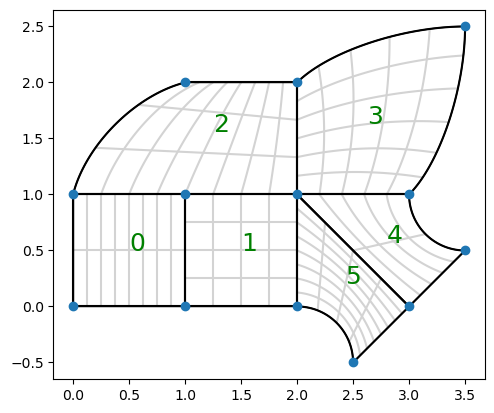

In [3]:
MP.mesh.draw(knots=1, nodes=1, patch_idx=1)

In [4]:
#MP.h_refine({2:None})
for i in range(9):
    MP.h_refine(-1)
    print(MP.numdofs)

Refinement took 0.0015304088592529297 seconds for 6 patches.
setting up constraints took 0.03286099433898926 seconds.
Basis setup took 0.01323556900024414 seconds
682
Refinement took 0.0005130767822265625 seconds for 6 patches.
setting up constraints took 0.025909900665283203 seconds.
Basis setup took 0.009998798370361328 seconds
2376
Refinement took 0.0003998279571533203 seconds for 6 patches.
setting up constraints took 0.026726484298706055 seconds.
Basis setup took 0.010077714920043945 seconds
8836
Refinement took 0.0003135204315185547 seconds for 6 patches.
setting up constraints took 0.02816462516784668 seconds.
Basis setup took 0.01588273048400879 seconds
34044
Refinement took 0.00031685829162597656 seconds for 6 patches.
setting up constraints took 0.0475919246673584 seconds.
Basis setup took 0.0514070987701416 seconds
133612
Refinement took 0.00036716461181640625 seconds for 6 patches.
setting up constraints took 0.09637928009033203 seconds.
Basis setup took 0.16725707054138184

In [14]:
%timeit algebra_cy.pyx_compute_basis(*MP.Constr.shape, MP.Constr, maxiter=10)
%timeit algebra.compute_basis(MP.Constr, maxiter=10)

230 ms ± 7.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
531 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
